In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import time

from scipy.stats import pearsonr
from datetime import datetime, date, timedelta
from scipy.optimize import differential_evolution
from sklearn.metrics import r2_score, mean_squared_error
from pandas.api.types import is_numeric_dtype
from pandas.api.types import is_datetime64_any_dtype as is_datetime


In [2]:
working_directory = "C:/Users/wachic/OneDrive - Milwaukee School of Engineering/Documents/GitHub/Undergrad_Research/"

# Naming convention
# MMSD_sewerflow_all_dailyavg_df
# 1.  [MMSD, USGS] Where the source is
# 2.  [sewerflow, precip, streamflow] What the data measures
# 3.  [all, dry, wet] what season it includes
# 4-n What ever operation has been done to the data
# n+1 [df, periods, csv] data type

USGS_stream_flow_all_df = pd.read_csv(working_directory + "USGS 04087030 Streamflow Cleaned.csv")
MMSD_sewerflow_all_df = pd.read_csv(working_directory + "MMSD Sewer Flow Cleaned.csv")
MMSD_flow_and_precip_all_df = pd.read_csv(working_directory + "MMSD Flow and Precipitation Cleaned.csv")
MMSD_precip_all_df = pd.read_csv(working_directory + "MMSD Precipitation Raw Data Cleaned.csv")
MMSD_sewerflow_diurnal_removed_df = pd.read_csv(working_directory + "MMSD_sewerflow_diurnal_removed_df.csv")
MMSD_sewerflow_predicted_precipitation_df = pd.read_csv(working_directory + "MMSD_sewerflow_predicted_precipitation_df.csv")
MMSD_sewerflow_baseflow_df = pd.read_csv(working_directory + "MMSD_sewerflow_baseflow_df.csv")
weighted_precip_for_streamgage_df = pd.read_csv(working_directory + "MMSD_weighted_precip_for_streamgage_df.csv")

df_list = [USGS_stream_flow_all_df,
           MMSD_sewerflow_all_df,
           MMSD_flow_and_precip_all_df,
           MMSD_precip_all_df,
           MMSD_sewerflow_diurnal_removed_df,
           MMSD_sewerflow_predicted_precipitation_df,
           MMSD_sewerflow_baseflow_df,
           weighted_precip_for_streamgage_df]

In [3]:
for df in df_list:
    df['Date Time'] = pd.to_datetime(df['Date Time'])

In [4]:
def export(df, name='export_df'):
    csv = df.to_csv(f'{name}.csv', index = False) 

### Luedke model

In [5]:
def insert_mirrored_rows(df, num_rows=30):
    """
    Insert chronologically mirrored data point at head and tail of df
    """
    df = df.copy()
    mirrored_rows_head = df.iloc[:num_rows].copy()
    mirrored_rows_head = mirrored_rows_head.iloc[::-1].reset_index(drop=True)

    mirrored_rows_tail = df.iloc[-num_rows:].copy()
    mirrored_rows_tail = mirrored_rows_tail.iloc[::-1].reset_index(drop=True)

    df_extended = pd.concat([mirrored_rows_head, df, mirrored_rows_tail], ignore_index=True)
    
    return df_extended

def moving_avg(df, length=24):
    """ 
    Finds moving average for past 24 hour
    """
    df = insert_mirrored_rows(df.copy()).drop(columns=['Date Time'], inplace=False)
    out_df = df.rolling(window=length).mean()
    return out_df.iloc[30:-30]

def normalize(df):
    df_normalized = df.copy()
    df_normalized = (df - df.min()) / (df.max() - df.min())
    return df_normalized

In [6]:
def get_event(flow_df, precip_df):
    precip_df = precip_df.copy()
    flow_df = flow_df.copy()
    
    precip_df = moving_avg_mid(precip_df, [24])
    flow_df = moving_avg_mid(flow_df, [24])
    
    precip_df.set_index("Date Time", inplace=True)
    flow_df.set_index("Date Time", inplace=True)

    flow_col_name = flow_df.columns[0]
    precip_col_name = precip_df.columns[0]
    
    events = []
    in_event = False
    original_flow = flow_df[flow_col_name].min() * 18
    event_start = None
    
    for date in precip_df.index:
        if not in_event and precip_df.loc[date, precip_col_name] > 0.0:
            event_start = date
            in_event = True  
            
        if in_event:
            flow_value = flow_df.loc[date, flow_col_name] 
            
            if pd.isna(flow_value) or (flow_value <= original_flow * 1.5):
                event_end = date
                events.append((event_start, event_end))
                in_event = False  
    
    merged_events = []
    for i in range(len(events)):
        if i == 0:
            merged_events.append(events[i])
        else:
            prev_start, prev_end = merged_events[-1]
            curr_start, curr_end = events[i]
    
            if (curr_start - prev_end) <= timedelta(hours=6):
                merged_events[-1] = (prev_start, curr_end)
            else:
                merged_events.append(events[i])

    filtered_events = []
    for start, end in merged_events:
        if (end - start) >= timedelta(hours=18):
            max_flow = flow_df.loc[start:end, flow_col_name].max()
            if max_flow > 0.7:
                filtered_events.append((start, end))

    return filtered_events

In [7]:
def luedke_2_level(streamflow_df, precip_df, stream_flow_avg_time_step=3, precip_avg_time_step=3, catch_area=60, RD=0.5, RW_max=1, HHL=13):
    streamflow_df = streamflow_df.copy()
    precip_df = precip_df.copy()
    
    # Level 2
    MASF_t_df = moving_avg(streamflow_df, stream_flow_avg_time_step)  # (13)
    MASF_scaled_df = normalize(MASF_t_df)  # (12)
    RW_t_df = RW_max * MASF_scaled_df  # (11)
    
    # Level 1
    MAP_t = moving_avg(precip_df, precip_avg_time_step)  # (3)
    shape_factor = 0.5 ** (1 / HHL)  # (2)
    RW_nd = RW_t_df.to_numpy().reshape(-1, 1)
    Q_t_nd = np.copy(RW_nd)
    MAP_nd = MAP_t.to_numpy().reshape(-1, 1)
    
    for row_i in range(1, len(RW_nd)):
        Q_t_nd[row_i] = catch_area * (
            RD + ((RW_nd[row_i] + RW_nd[row_i - 1]) / 2)
        ) * MAP_nd[row_i] * (1 - shape_factor) + (shape_factor * Q_t_nd[row_i - 1])
    
    return np.squeeze(pd.DataFrame(Q_t_nd))

def luedke_3_level(streamflow_df, precip_df, precip_avg_time_step=1, catch_area=60, RD=0.5, HHL=15, AMHL=10, cold_shcf=0.4, hot_shcf=0.4):
    streamflow_df = streamflow_df.copy()
    precip_df = precip_df.copy()
    
    # Level 3
    L = 1.2 * (cold_shcf - hot_shcf)  # (7)
    k = 4.7964 / (30 - 70)  # (8)
    x_0 = (70 + 30) / 2  # (9)
    MASF_t_df = moving_avg(streamflow_df, precip_avg_time_step)  # (13)
    MASF_scaled_df = 70 - (normalize(MASF_t_df) * 40)  # (15)
    SHCF_t = (L / (1 + np.exp(-k * (MASF_scaled_df - x_0)))) + cold_shcf - (11/12) * L  # (14)
    
    # Level 2
    MAP_t = moving_avg(precip_df, precip_avg_time_step)  # (3)
    AMRF = 0.5 ** (1 / AMHL)  # (5)
    SHCF_nd = SHCF_t.to_numpy().reshape(-1, 1)
    RW_nd = np.copy(SHCF_nd)
    MAP_nd = MAP_t.to_numpy().reshape(-1, 1)
    
    for row_i in range(1, len(RW_nd)):
        RW_nd[row_i] = (AMRF - 1) / np.log(AMRF) * SHCF_nd[row_i] * MAP_nd[row_i] + (AMRF * RW_nd[row_i - 1])  # (4)
        if np.log(AMRF) == 0:
            print(np.log(AMRF))
    # Level 1
    shape_factor = 0.5 ** (1 / HHL)  # (2)
    Q_t_nd = np.copy(RW_nd)
    
    for row_i in range(1, len(Q_t_nd)):
        Q_t_nd[row_i] = catch_area * (
            RD + ((RW_nd[row_i] + RW_nd[row_i - 1]) / 2)
        ) * MAP_nd[row_i] * (1 - shape_factor) + (shape_factor * Q_t_nd[row_i - 1])
    
    return np.squeeze(pd.DataFrame(Q_t_nd))

In [8]:
def trim(df, start, end):
    return df[(df['Date Time'] >= start) & (df['Date Time'] <= end)].reset_index(drop = True)
    

In [9]:
# 2015-04-06 10:00:00 2015-04-16 07:00:00
# 2018-09-29 08:00:00 2018-10-13 13:00:00

In [10]:
# MMSD_sewerflow_predicted_precipitation_range_df = trim(MMSD_sewerflow_predicted_precipitation_df.copy(), pd.to_datetime('2015-04-06 10:00:00'), pd.to_datetime('2015-04-16 07:00:00'))
# weighted_precip_for_streamgage_range_df = trim(weighted_precip_for_streamgage_df.copy(), pd.to_datetime('2015-04-06 10:00:00'), pd.to_datetime('2015-04-16 07:00:00'))

In [11]:
# weighted_precip_for_streamgage_range_df.head(4)

In [12]:
# def optimize_luedke2(date_time_df, flow_df, precip_df, catchment_area = 50, time_step_hours = 1):
#     def objective(params):
#         # unpack the 6 parameters
#         p1, p2, p3 = params
        
#         # run your predictive model
#         predictions = luedke_2_level(flow_df, precip_df, time_step_hours, time_step_hours, catchment_area, p1, p2, p3)

#         l2_data = pd.DataFrame({
#             'Date Time': date_time_df,
#             'Observed': flow_df,
#             'Simulated': predictions
#         })
        
#         l2_data['Date Time'] = pd.to_datetime(l2_data['Date Time'])
#         l2_data.set_index('Date Time', inplace=True)
#         if MSDGC is True:
#             r, p_value = pearsonr(l2_data['Observed'], l2_data['Simulated'])
    
#             stdev_obs = l2_data['Observed'].std()
#             stdev_sim = l2_data['Simulated'].std()
    
#             C_b = (2*stdev_obs*stdev_sim)/((stdev_obs**2)+(stdev_sim**2)+(stdev_obs-stdev_sim)**2)
#             return -r*C_b
#         if MSDGC is False:
#             # calculate R² score
#             r2 = r2_score(l2_data['Observed'], l2_data['Simulated'])
#             r2 = (-r2 + 1)/2 # 1
            
#             observed_volume = np.sum(l2_data['Observed']) * time_step_hours
#             simulated_volume = np.sum(l2_data['Simulated']) * time_step_hours
            
#             volume_error_percent = abs((simulated_volume - observed_volume) / observed_volume) # 2
    
#             observed_peak_flow = l2_data['Observed'].max()
#             simulated_peak_flow = l2_data['Simulated'].max()
#             peak_flow_perc = abs((simulated_peak_flow - observed_peak_flow) / observed_peak_flow) # 3
            
#             observed_peak_time = l2_data['Observed'].idxmax()
#             simulated_peak_time = l2_data['Simulated'].idxmax()
#             peak_time_lag = abs(simulated_peak_time - observed_peak_time).total_seconds() / 3600 # 4

#             r, p_value = pearsonr(l2_data['Observed'], l2_data['Simulated'])
    
#             stdev_obs = l2_data['Observed'].std()
#             stdev_sim = l2_data['Simulated'].std()
    
#             C_b = (2*stdev_obs*stdev_sim)/((stdev_obs**2)+(stdev_sim**2)+(stdev_obs-stdev_sim)**2) # 5
            
#             mod = (-r*C_b)+(volume_error_percent+peak_flow_perc)*0.2
#             return mod
    
#     # Define parameter bounds [(min, max) for each of the 5 params]
#     bounds = [(0, 1), (0, 1), (0, 20)]
    
#     result = differential_evolution(objective, bounds)
    
#     # Best parameters
#     best_params = result.x
    
#     # Best meteric
#     best_meter = result.fun

#     ###############################
#     bp1, bp2, bp3 = best_params
#     best_fit = luedke_2_level(flow_df, precip_df, time_step_hours, time_step_hours, catchment_area, bp1, bp2, bp3)

#     # Build the DataFrame cleanly
#     best_l2_data = pd.DataFrame({
#         'Date Time': date_time_df,
#         'Observed': flow_df,
#         'Simulated': best_fit
#     })
    
#     best_l2_data['Date Time'] = pd.to_datetime(best_l2_data['Date Time'])
#     best_l2_data.set_index('Date Time', inplace=True)

#     r2 = r2_score(best_l2_data['Observed'], best_l2_data['Simulated']) # 1
#     observed_volume = np.sum(best_l2_data['Observed']) * time_step_hours
#     simulated_volume = np.sum(best_l2_data['Simulated']) * time_step_hours
        
#     volume_error_percent = ((simulated_volume - observed_volume) / observed_volume) # 2

#     observed_peak_flow = best_l2_data['Observed'].max()
#     simulated_peak_flow = best_l2_data['Simulated'].max()
#     peak_flow_perc = (simulated_peak_flow - observed_peak_flow) / observed_peak_flow # 3

#     observed_peak_time = best_l2_data['Observed'].idxmax()
#     simulated_peak_time = best_l2_data['Simulated'].idxmax()
#     peak_time_lag = (simulated_peak_time - observed_peak_time).total_seconds() / 3600 # 4

#     print('Optimized parameter')
#     print(f'RD - Rainfall capture fraction dry:\t\t\t{bp1}')
#     print(f'RDW max - max rainfall fraction for wet:\t\t{bp2}')
#     print(f'HHL - hydrograph recession time:\t\t\t{bp3}')
#     print('Resulting metric')
#     print(f'r^2:\t\t\t\t\t\t\t{r2}')
#     print(f'volume percentage error:\t\t\t\t{volume_error_percent*100} %')
#     print(f'peak flow percentage error:\t\t\t\t{peak_flow_perc*100} %')
#     print(f'lag time for peak flow:\t\t\t\t\t{peak_time_lag} Hours')
#     ##################################
#     plt.figure(figsize=(15, 6))
    
#     plt.plot(best_l2_data.index, best_l2_data['Observed'], linestyle='-', color='g', markersize=6, label="Observed Flow")
#     plt.plot(best_l2_data.index, best_l2_data['Simulated'], linestyle='-', color='b', markersize=6, label="Luedke Model")

#     flow_max = best_l2_data['Observed'].max()
#     flip_precip = (flow_max*1.4) - precip_df*2.5
#     plt.plot(best_l2_data.index, flip_precip, linestyle='-', color='r', markersize=6, label="Precipitation")
    
#     plt.gca().xaxis.set_major_locator(mdates.DayLocator()) 
#     plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d %b %Y')) 
    
#     plt.title('Luedke 2 level model')
#     plt.xticks(rotation=45)
#     plt.grid(True)
#     plt.legend()
    
#     plt.show()
#     return best_l2_data

In [13]:
def optimize_luedke3(MSDGC, date_time_df, flow_df, precip_df, catchment_area = 50, time_step_hours = 1):
    def objective(params):
        # unpack the 6 parameters
        p1, p2, p3, p4, p5 = params
        
        # run your predictive model
        predictions = luedke_3_level(flow_df, precip_df, time_step_hours, catchment_area, p1, p2, p3, p4, p5)

                # Build the DataFrame cleanly
        l3_data = pd.DataFrame({
            'Date Time': date_time_df,
            'Observed': flow_df,
            'Simulated': predictions
        })
        
        l3_data['Date Time'] = pd.to_datetime(l3_data['Date Time'])
        l3_data.set_index('Date Time', inplace=True)
        if MSDGC is True:
            r, p_value = pearsonr(l3_data['Observed'], l3_data['Simulated'])
    
            stdev_obs = l3_data['Observed'].std()
            stdev_sim = l3_data['Simulated'].std()
    
            C_b = (2*stdev_obs*stdev_sim)/((stdev_obs**2)+(stdev_sim**2)+(stdev_obs-stdev_sim)**2)
            return -r*C_b
        if MSDGC is False:
            # calculate R² score
            r2 = r2_score(l3_data['Observed'], l3_data['Simulated'])
            r2 = (-r2 + 1)/2 # 1
            
            observed_volume = np.sum(l3_data['Observed']) * time_step_hours
            simulated_volume = np.sum(l3_data['Simulated']) * time_step_hours
            
            volume_error_percent = abs((simulated_volume - observed_volume) / observed_volume) # 2
    
            observed_peak_flow = l3_data['Observed'].max()
            simulated_peak_flow = l3_data['Simulated'].max()
            peak_flow_perc = abs((simulated_peak_flow - observed_peak_flow) / observed_peak_flow) # 3
            
            observed_peak_time = l3_data['Observed'].idxmax()
            simulated_peak_time = l3_data['Simulated'].idxmax()
            peak_time_lag = abs(simulated_peak_time - observed_peak_time).total_seconds() / 3600 # 4

            r, p_value = pearsonr(l3_data['Observed'], l3_data['Simulated'])
    
            stdev_obs = l3_data['Observed'].std()
            stdev_sim = l3_data['Simulated'].std()
    
            C_b = (2*stdev_obs*stdev_sim)/((stdev_obs**2)+(stdev_sim**2)+(stdev_obs-stdev_sim)**2) # 5
            
            mod = (-r*C_b)+(volume_error_percent+peak_flow_perc)*0.2
            return mod
    # Define parameter bounds [(min, max) for each of the 5 params]
    bounds = [(0, 1), (0, 20), (0, 20), (0, 1), (0, 1)]
    
    result = differential_evolution(objective, bounds)
    
    # Best parameters
    best_params = result.x
    
    # Best meteric
    best_meter = result.fun

    ###############################
    bp1, bp2, bp3, bp4, bp5 = best_params
    best_fit = luedke_3_level(flow_df, precip_df, time_step_hours, catchment_area, bp1, bp2, bp3, bp4, bp5)

    # Build the DataFrame cleanly
    best_l3_data = pd.DataFrame({
        'Date Time': date_time_df,
        'Observed': flow_df,
        'Simulated': best_fit
    })
    
    best_l3_data['Date Time'] = pd.to_datetime(best_l3_data['Date Time'])
    best_l3_data.set_index('Date Time', inplace=True)

    r2 = r2_score(best_l3_data['Observed'], best_l3_data['Simulated']) # 1
    
    observed_volume = np.sum(best_l3_data['Observed']) * time_step_hours
    simulated_volume = np.sum(best_l3_data['Simulated']) * time_step_hours
        
    volume_error_percent = (simulated_volume - observed_volume) / observed_volume # 2

    observed_peak_flow = best_l3_data['Observed'].max()
    simulated_peak_flow = best_l3_data['Simulated'].max()
    peak_flow_perc = (simulated_peak_flow - observed_peak_flow) / observed_peak_flow # 3
    
    observed_peak_time = best_l3_data['Observed'].idxmax()
    simulated_peak_time = best_l3_data['Simulated'].idxmax()
    peak_time_lag = (simulated_peak_time - observed_peak_time).total_seconds() / 3600 # 4
    
    r, p_value = pearsonr(best_l3_data['Observed'], best_l3_data['Simulated'])
    stdev_obs = best_l3_data['Observed'].std()
    stdev_sim = best_l3_data['Simulated'].std()
    C_b = (2*stdev_obs*stdev_sim)/((stdev_obs**2)+(stdev_sim**2)+(stdev_obs-stdev_sim)**2) # 5
    
    print('Optimized parameter')
    print(f'RD - Rainfall capture fraction dry:\t\t\t{bp1}')
    print(f'HHL - hydrograph recession time:\t\t\t{bp2}')
    print(f'AMHL - duration of antevedent effect:\t\t\t{bp3}')
    print(f'cold_shcf - increase in capture fraction in winter:\t{bp4}')
    print(f'hot_shcf - increase in capture fraction in summer:\t{bp5}')
    print('Resulting metric')
    print(f'r^2:\t\t\t\t\t\t\t{r2}')
    print(f'r*C_b:\t\t\t\t\t\t\t{r*C_b}')
    print(f'volume percentage error:\t\t\t\t{volume_error_percent*100} %')
    print(f'peak flow percentage error:\t\t\t\t{peak_flow_perc*100} %')
    print(f'lag time for peak flow:\t\t\t\t\t{peak_time_lag} Hours')
    
    ##################################
    plt.figure(figsize=(15, 6))
    
    plt.plot(best_l3_data.index, best_l3_data['Observed'], linestyle='-', color='g', markersize=6, label="Observed Flow")
    plt.plot(best_l3_data.index, best_l3_data['Simulated'], linestyle='-', color='b', markersize=6, label="Luedke Model")

    flow_max = best_l3_data['Observed'].max()
    flip_precip = (flow_max*1.4) - precip_df*2.5
    plt.plot(best_l3_data.index, flip_precip, linestyle='-', color='r', markersize=6, label="Precipitation")
    
    plt.gca().xaxis.set_major_locator(mdates.DayLocator()) 
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d %b %Y')) 
    
    plt.title('Luedke 3 level model')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    
    plt.show()
    return best_l3_data

In [14]:
# %%time
# optimized_l3_MSDGC_df = optimize_luedke3(True, MMSD_sewerflow_predicted_precipitation_range_df['Date Time'], MMSD_sewerflow_predicted_precipitation_range_df['MS0311 Flow'], weighted_precip_for_streamgage_range_df['40869416'], 60, 1)

In [15]:
# %%time
# optimized_l3_df = optimize_luedke3(False, MMSD_sewerflow_predicted_precipitation_range_df['Date Time'], MMSD_sewerflow_predicted_precipitation_range_df['MS0311 Flow'], weighted_precip_for_streamgage_range_df['40869416'], 60, 1)

In [16]:
# optimized_l2_df = optimize_luedke2(MMSD_sewerflow_predicted_precipitation_range_df['Date Time'], MMSD_sewerflow_predicted_precipitation_range_df['MS0311 Flow'], weighted_precip_for_streamgage_range_df['40869416'], 60, 1)

In [17]:
# # Example: highlight data from '2021-06-01 00:00' to '2021-06-05 23:00'
# pre_conveyance_range = (optimized_l3_df.index <= '2015-04-09 08:00') 
# overflow_range = (optimized_l3_df.index >= '2015-04-09 08:00') & (optimized_l3_df.index <= '2015-04-10 06:00')
# post_conveyance_range = (optimized_l3_df.index >= '2015-04-10 06:00') 
# # Split the data

# pre_conveyance = optimized_l3_df[pre_conveyance_range]
# overflow = optimized_l3_df[overflow_range]
# post_conveyance = optimized_l3_df[post_conveyance_range]

# plt.figure(figsize=(15, 6))

# # Plot normal points
# plt.scatter(pre_conveyance['Simulated'], pre_conveyance['Observed'], color='g', s=7, label="Pre Conveyance")
# plt.scatter(overflow['Simulated'], overflow['Observed'], color='r', s=7, label="Overflow")
# plt.scatter(post_conveyance['Simulated'], post_conveyance['Observed'], color='b', s=7, label="Post Conveyance")

# # Optional: keep line plots
# plt.plot(optimized_l3_df['Simulated'], optimized_l3_df['Observed'], color='g', alpha=0.3, label="Simulated vs Observed Line")
# plt.plot(optimized_l3_df['Observed'], optimized_l3_df['Observed'], color='purple', linestyle='--', label="1:1 Line")

# plt.title('Luedke 3 Level Model')
# plt.grid(True)
# plt.legend()
# plt.show()


In [18]:
# plt.figure(figsize=(15, 6))

# plt.scatter(optimized_l3_df['Simulated'], optimized_l3_df['Observed'], color='g', s=5)
# plt.plot(optimized_l3_df['Simulated'], optimized_l3_df['Observed'], color='g', markersize=4, label="Orig Metric")

# plt.scatter(optimized_l3_MSDGC_df['Simulated'], optimized_l3_MSDGC_df['Observed'], color='b', s=5)
# plt.plot(optimized_l3_MSDGC_df['Simulated'], optimized_l3_MSDGC_df['Observed'], color='b', markersize=4, label="MSDGC Metric")

# plt.plot(optimized_l3_df['Observed'], optimized_l3_df['Observed'], color='r', markersize=4, label="Observed Flow")
# plt.title('Luedke 3 level model')
# plt.grid(True)
# plt.legend()

# plt.show()

In [19]:
MMSD_sewerflow_predicted_precipitation_range_df = trim(MMSD_sewerflow_predicted_precipitation_df.copy(), pd.to_datetime('2018-09-29 08:00:00'), pd.to_datetime('2018-10-13 13:00:00'))
weighted_precip_for_streamgage_range_df = trim(weighted_precip_for_streamgage_df.copy(), pd.to_datetime('2018-09-29 08:00:00'), pd.to_datetime('2018-10-13 13:00:00'))


In [20]:
b1=0.3016002085876671
b2=10.243726521925295
b3=11.727835253280498
b4=0.9343607514182526
b5=0.10281739863056662
MMSD_sewerflow_predicted_precipitation_range_df.head(5)

,Date Time,MS0311 Flow,MS0311 Level,MS0311 Velocity,MS0312 Flow,MS0312 Level,MS0312 Velocity,MS0208 Flow,MS0208 Level,MS0208 Velocity,...,MS0131 Flow,MS0131 Level,MS0131 Velocity,MS0356 Flow,MS0356 Level,MS0356 Velocity,PS81CS Flow,PS81SS Flow,PS81TJ Flow,PS81TS Flow
0,2018-09-29 08:00:00,0.051646,0.020491,0.033576,0.182910,0.030439,0.206943,0.034571,0.014501,0.099613,...,NaN,NaN,NaN,0.035939,0.023535,0.014537,1.599549,10.942086,20.277418,-1.063248
1,2018-09-29 09:00:00,0.053279,0.019554,0.039096,0.207265,0.032515,0.227313,0.035704,0.015682,0.117348,...,NaN,NaN,NaN,0.037001,0.026898,0.015844,1.488293,9.504386,20.113818,-1.060364
2,2018-09-29 10:00:00,0.052741,0.018116,0.045264,0.235826,0.034436,0.255589,0.032134,0.015034,0.123787,...,NaN,NaN,NaN,0.034524,0.028231,0.015513,1.296733,7.630388,18.956466,-1.058034
3,2018-09-29 11:00:00,0.048968,0.016030,0.050395,0.259909,0.035803,0.281009,0.025571,0.013093,0.121144,...,NaN,NaN,NaN,0.030009,0.027806,0.014370,1.053673,5.603572,16.173815,-1.056270
4,2018-09-29 12:00:00,0.041532,0.013167,0.053104,0.271100,0.036254,0.291352,0.018635,0.011045,0.113674,...,NaN,NaN,NaN,0.025932,0.026786,0.013000,0.798756,3.780704,11.660928,-1.055086


In [21]:
event = luedke_3_level(MMSD_sewerflow_predicted_precipitation_range_df['MS0311 Flow'], weighted_precip_for_streamgage_range_df['40869416'], 1, 120, b1, b2, b3, b4, b5)

In [22]:

MMSD_precip_all_df2 = trim(MMSD_precip_all_df.copy(), pd.to_datetime('2018-09-29 08:00:00'), pd.to_datetime('2018-10-13 13:00:00'))

In [23]:
event.shape

(342,)

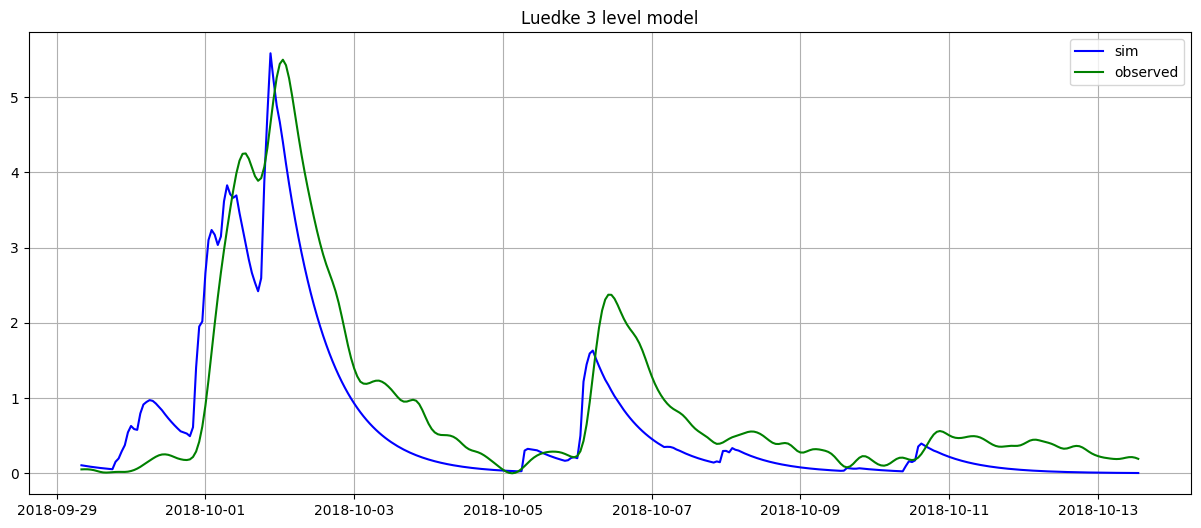

In [24]:
plt.figure(figsize=(15, 6))
MMSD_sewerflow_predicted_precipitation_range_df
plt.plot(MMSD_sewerflow_predicted_precipitation_range_df['Date Time'], event, color='b', markersize=4, label="sim")
plt.plot(MMSD_sewerflow_predicted_precipitation_range_df['Date Time'], MMSD_sewerflow_predicted_precipitation_range_df['MS0311 Flow'], color='g', markersize=4, label="observed")

# plt.scatter(optimized_l3_MSDGC_df['Simulated'], optimized_l3_MSDGC_df['Observed'], color='b', s=5)
# plt.plot(optimized_l3_MSDGC_df['Simulated'], optimized_l3_MSDGC_df['Observed'], color='b', markersize=4, label="MSDGC Metric")

# plt.plot(optimized_l3_df['Observed'], optimized_l3_df['Observed'], color='r', markersize=4, label="Observed Flow")
plt.title('Luedke 3 level model')
plt.grid(True)
plt.legend()

plt.show()